# Introduction

Deployment is the end goal of any Machine-Learning based project. Whilst this dataset provides conveniently labelled timings of each breathing cycle to train ML based models, extracting similar timings from new audio clips for a trained model remains an unresolved issue.

This notebook strives to produce an automated method of extracting breathing cycle timings from audio clips for ML model training, as well as to generate the input data for a deployed ML model.

The crux of the method revolves around peak detection of the sound intensity envelop. Estimates of the start and end of each breathing cycle are then fine-tuned using data from the hand-annotated breathing cycles. The following is a rough breakdown of the steps:

**Peak Extraction**

1. Noise Removal(Bandpass Filtering) + Log Compression
2. Computation of Intensity envelop from spectrogram
3. Peak detection of Guassian-smoothed peak intensity envelop (Left/Right Base of peaks also recorded)

**Breathing Cycle Start/End Estimate**

4. Represent the start/end of each cycle as the left/right base of each extracted peak with an outward offset
5. Among the detected peaks, use a min-weight Bipartite match to match peaks with the closest hand-annotated breathing cycle (Each cycle may only be paired with 1 peak, unpaired peaks are ignored)
6. Perform multivariate optimization to find the appropriate offset values to minimize the *mean* error of each start/end cycle with the paired hand-annotated breathing cycle timings.

After performing these steps, peaks may be extracted by finding a peak and the timing of the left & right bases. An audio clip is extracted from the left / right base with the offset found above added to get an audio clip of a breathing cycle.

For training data, labels can be transferred to the automatically detected cycle timings via Intersection over Union metrics.

In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

audioFilePaths = []
recordingInfoFilePaths = []
for dirname, _, filenames in os.walk('C:/Users/u144572/self_development/mgr/Respiratory_Sound_Database/audio_and_txt_files'):
    for filename in filenames:
        fullPath = os.path.join(dirname, filename)
        if filename.endswith("wav"):
            audioFilePaths.append(fullPath)
        elif filename.endswith("txt"):
            recordingInfoFilePaths.append(fullPath) 
        #print(os.path.join(dirname, filename))

print(len(audioFilePaths))
print(len(recordingInfoFilePaths))

920
920


In [58]:
import csv

def extractFilenameWithoutExtension(fullPath):
    fileName = os.path.basename(fullPath)
    fileNameWithoutPath = os.path.splitext(fileName)[0]
    return fileNameWithoutPath

#(fullPaths:string[]) => dict<filename:string, (start, end, hasCrackles, hasWheezes)[]>
def getFileInfoDict(pathList):
    fileInfoDict = {}
    for path in pathList:
        fileNameWithoutPath = extractFilenameWithoutExtension(path) 
        infoList = []
        with open(path, 'r') as hFile:
            reader = csv.reader(hFile, delimiter='\t')
            for row in reader:
                startTime = float(row[0])
                endTime = float(row[1])
                hasCrackles = True if int(row[2]) == 1 else False
                hasWheezes = True if int(row[3]) == 1 else False
                infoList.append((startTime, endTime, hasCrackles, hasWheezes))
                
        fileInfoDict[fileNameWithoutPath] = infoList
    return fileInfoDict
 
audioFilePathsWithoutExtension = [extractFilenameWithoutExtension(path) for path in audioFilePaths]
fileInfoDict = getFileInfoDict(recordingInfoFilePaths)
#List order is aligned with the order in which the audio clips are extracted
fileInfoList = [fileInfoDict[audioPath] for audioPath in audioFilePathsWithoutExtension] 

# Basic Pre-processing

All audio files are resampled to 7000Hz. The resultant Nyquist frequency is covers the range for lung sounds (25-1500Hz <a href="https://telehealthtechnology.org/toolkit/electronic-stethoscopes-technology-overview/">[1]</a>).

Due to the prevalance of handling noise (bumps/knocks), which manifest as Low-Frequency noise, a brick-wall high pass filter of 80Hz is applied.

Log Compression is then used to reduce the differences in dynamic range within the audio clips.

In [59]:
import librosa

gSampleRate = 7000

def loadFiles(fileList):
    outputBuffers = []
    for filename in fileList:
        audioBuffer, nativeSampleRate = librosa.load(filename, dtype=np.float32, mono=True, sr=None)
        if nativeSampleRate == gSampleRate:
            outputBuffers.append(audioBuffer)
        else:
        #Linear resampling using numpy is significantly faster than Librosa's default technique
            duration = len(audioBuffer) / nativeSampleRate
            nTargetSamples = int(duration * gSampleRate)
            timeXSource = np.linspace(0, duration, len(audioBuffer), dtype=np.float32)
            timeX = np.linspace(0, duration, nTargetSamples, dtype=np.float32)
            resampledBuffer = np.interp(timeX, timeXSource, audioBuffer)
            outputBuffers.append(resampledBuffer)
            
    return outputBuffers

audioBuffers = loadFiles(audioFilePaths)

In [60]:
from scipy import signal
import matplotlib.pyplot as plt

upperCutoffFreq = 3000
cutoffFrequencies = [80, upperCutoffFreq]

#FIR coefficients for a bandpass filter with a window of 80-3000 Hz
highPassCoeffs = signal.firwin(401, cutoffFrequencies, fs=gSampleRate, pass_zero="bandpass")

def applyHighpass(npArr):
    return signal.lfilter(highPassCoeffs, [1.0], npArr)

#Higher gamma results in more aggressive compression
def applyLogCompressor(signal, gamma):
    sign = np.sign(signal)
    absSignal = 1 + np.abs(signal) * gamma
    logged = np.log(absSignal)
    scaled = logged * (1 / np.log(1.0 + gamma)) #Divide by the maximum possible value from compression
    return sign * scaled

#Scales all samples to ensure the peak signal is 1/-1
def normalizeVolume(npArr):
    minAmp, maxAmp = (np.amin(npArr), np.amax(npArr))
    maxEnv = max(abs(minAmp), abs(maxAmp))
    scale = 1.0 / maxEnv
    #in place multiply
    npArr *= scale
    return npArr

#Removing the low-freq noise, re-normalizing volume then apply compressor
noiseRemoved = [normalizeVolume(applyHighpass(buffer)) for buffer in audioBuffers]
noiseRemoved = [applyLogCompressor(sig, 30) for sig in noiseRemoved]

In [63]:
audioBuffers[1]

array([-0.03677356, -0.03715504, -0.03746326, ..., -0.04027545,
       -0.04160551, -0.04315174])

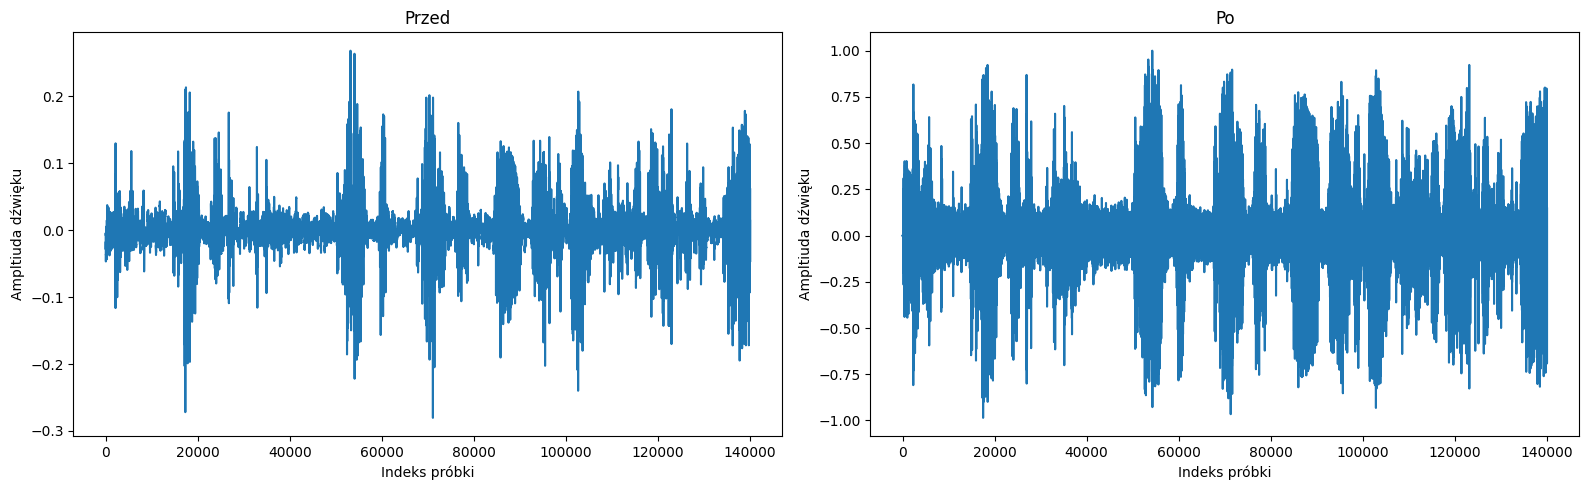

Przed


Po


In [72]:
import IPython.display as ipd

fig, axs = plt.subplots(1,2, figsize=(16,5))

selectedSampleIdx = 11

# fig.suptitle('Sygnał dźwiękowy przed i po redukcji szumów i kompresji logarytmicznej.', fontsize=18)

axs[0].plot(audioBuffers[selectedSampleIdx])
axs[0].set_title("Przed")

axs[1].plot(noiseRemoved[selectedSampleIdx])
axs[1].set_title("Po")

for ax in axs.flat:
    ax.set(ylabel='Ampltiuda dźwięku', xlabel='Indeks próbki')    

plt.tight_layout() 
plt.show()

print("Przed")
ipd.display(ipd.Audio(audioBuffers[selectedSampleIdx], rate=gSampleRate))
print("Po")
ipd.display(ipd.Audio(noiseRemoved[selectedSampleIdx], rate=gSampleRate))

# Peak detection from Spectrograms

Spectrograms are generated using a FFT window size of 50ms. The resultant bins in the spectrogram are multiplied by the square of their frequency, as the power of a sound wave is given by the following relation:

$$ P \propto Amplitude^{2} \times Frequency^{2}$$

The amplitude square relation is ignored in this case since omitting it results in cleaner peaks.

To filter out transients (i.e. knocks), a Guassian filter is used to smooth out the curve. Peak detection is then performed on the smoothed curve. The timings corresponding to the left/ right bases (relative to 80% of peak height) of each peak are then recorded.

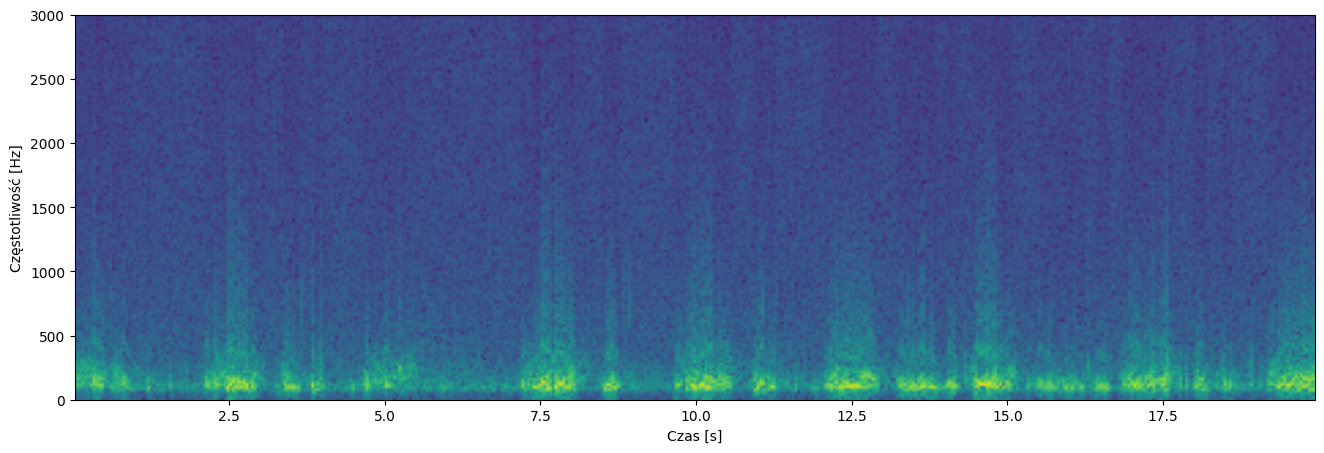

In [73]:
windowSizeSeconds = 0.05 
windowSampleSize = int(gSampleRate * windowSizeSeconds)

def plotSpectrogram(specData):
    plt.figure(figsize=(16,5))
    #Gamma scaling factor of 0.1 needed to make spectrogram more readable
    plt.pcolormesh(specData[1], specData[0], np.power(specData[2],0.1) , shading='gouraud')
    plt.ylim(0, upperCutoffFreq)
    plt.ylabel('Częstotliwość [Hz]')
    plt.xlabel('Czas [s]')
    plt.show()
    
#(audioBuffers:float[][]) => (frequencies:float[], time(seconds):float[], amplitudes:float[][]))[]
def getSpectrograms(audioBuffers):
    spectrograms = []
    for buffer in audioBuffers:
        freqTable, times, powerSpectrum = signal.spectrogram(buffer, gSampleRate, nperseg=windowSampleSize)
        spectrograms.append((freqTable, times, powerSpectrum))
    return spectrograms

spectrograms = getSpectrograms(noiseRemoved)
plotSpectrogram(spectrograms[selectedSampleIdx])

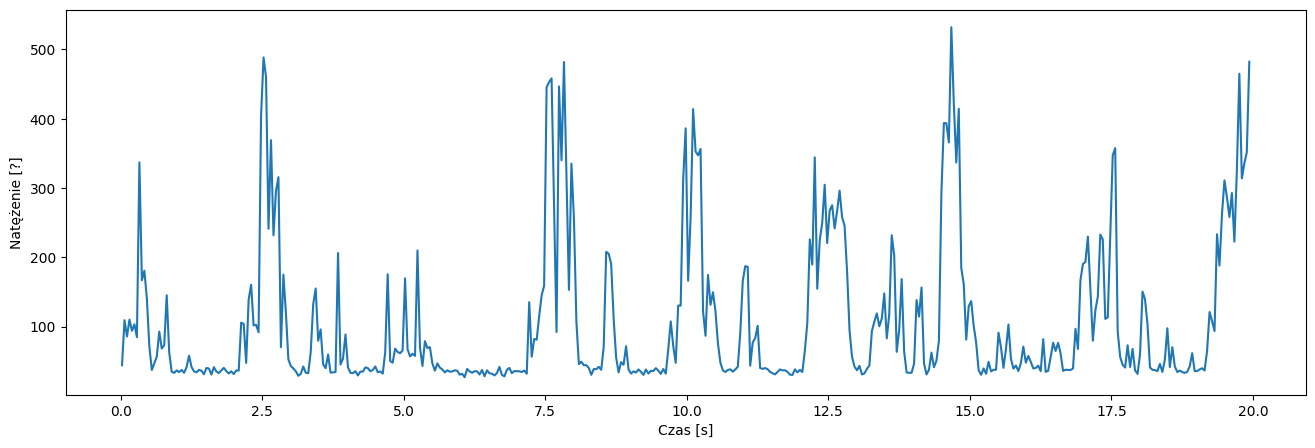

In [74]:
#(spectrogram:float[][], cutoffFreq(hz):float, plot:bool) => (times:float, amplitudes:float[])
def getPowerEnvelop(spectrogram, cutoff, plot=False):
    frequencies = spectrogram[0]
    timeSlices = spectrogram[1]
    spectrum = spectrogram[2]
    
    maxInd = np.sum(frequencies <= cutoff)
    truncFreq = frequencies[:maxInd]
    
    powerEnvelop = []
    for idx, _ in enumerate(timeSlices):
        freqAmplitudes = spectrum[:maxInd,idx]
        
        powerBins = freqAmplitudes * np.square(truncFreq)
        powerEnvelop.append(sum(powerBins))
    if (plot): 
        plt.figure(figsize=(16,5))
        plt.plot(timeSlices, powerEnvelop)
        plt.xlabel("Czas [s]")
        plt.ylabel("Natężenie [?]")
        plt.show()
        
    return (timeSlices, powerEnvelop)

time, amp = getPowerEnvelop(spectrograms[selectedSampleIdx], upperCutoffFreq, True)

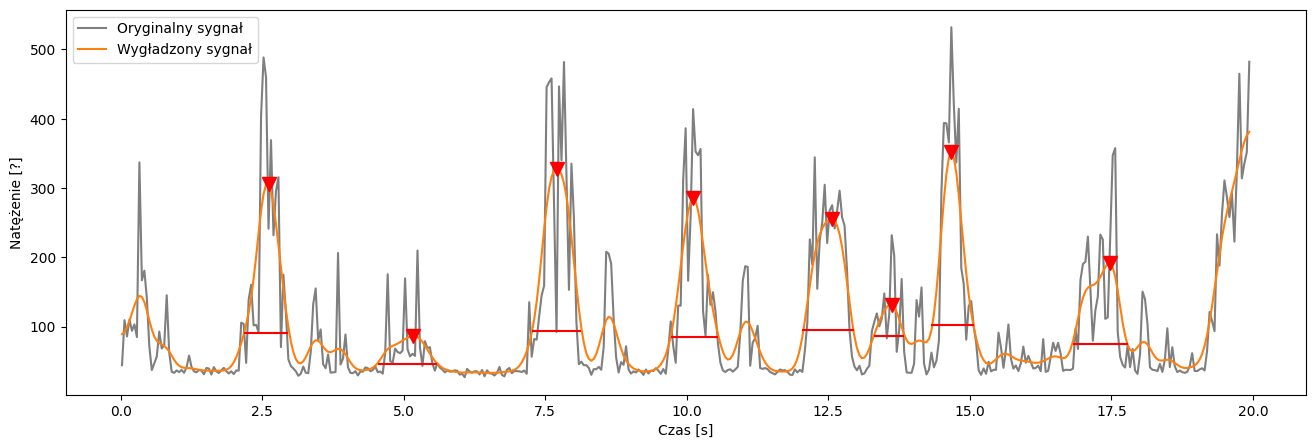

In [76]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.signal import peak_widths
import math

#(amplitudes:float[], time(seconds):float[], sampleInterval(seconds):float, minPeakDuration(seconds):float, gaussainSmoothingSigma:float, peakRelHeight(0-1):float, plot:bool) =>
#(smoothed:float[], peakTiming(seconds):float[], leftRightBoundaries:(left(seconds):float, right(seconds):float)[])
def findPeaksAndWidthsFromSmoothedCurve(amplitudes,time, sampleInterval, minPeakDuration=0.4, gaussianSmoothingSigma = 3, peakRelHeight=0.8, plot=False):
    smoothed = gaussian_filter1d(amplitudes, gaussianSmoothingSigma)
    minPeakDurationSamples = int(math.ceil(minPeakDuration / sampleInterval))
    peakIndices, _ = find_peaks(smoothed, width=minPeakDurationSamples) 
    peakWidthResult = peak_widths(smoothed, peakIndices, peakRelHeight)
    
    leftPeakTimes = time[np.rint(peakWidthResult[2]).astype(int)]
    rightPeakTimes = time[np.rint(peakWidthResult[3]).astype(int)]
    leftRightBoundaries = list(zip(leftPeakTimes, rightPeakTimes))
    
    peakTiming = time[peakIndices]
    if plot:
        plt.figure(figsize=(16,5))
        plt.plot(time, amplitudes, color="tab:gray", label="Oryginalny sygnał") 
        plt.plot(time, smoothed, color="tab:orange", label="Wygładzony sygnał")
        plt.plot(peakTiming, smoothed[peakIndices], "v", color="red", markersize=10)
        plt.hlines(peakWidthResult[1], leftPeakTimes , rightPeakTimes , color="red")
        plt.xlabel("Czas [s]")
        plt.ylabel("Natężenie [?]")
        plt.legend()
        plt.show()
        
    return (smoothed, peakTiming, leftRightBoundaries)
    

_  = findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds, plot=True)

In [10]:
#Calulate power envelop from sepctrogram
#(time(s):float[], amp:float[]) 
powerEnvelops = [getPowerEnvelop(spectrogram, upperCutoffFreq, False) for spectrogram in spectrograms]

In [11]:
from sklearn.model_selection import train_test_split

trainIndices, testIndices = train_test_split(range(len(recordingInfoFilePaths)), test_size=0.2, random_state=0xDEADBEEF)

def multiIndexList(sourceList, indices):
    return [obj for idx, obj in enumerate(sourceList) if idx in indices]

trainFileNames = multiIndexList(audioFilePathsWithoutExtension, trainIndices)
testFileNames = multiIndexList(audioFilePathsWithoutExtension, testIndices)

In [12]:
#Peak identification from power envelop
#(smoothedSignal:float[], peakTiming:seconds[], peakLeftRightBoundaries:(left:float,right:float)[])[]
peakData = [findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds) for time, amp in powerEnvelops]
trainPeakData =  multiIndexList(peakData, trainIndices)
testPeakData =  multiIndexList(peakData, testIndices)

# Obtaining the left/right offsets for each breathing cycle

The left/right peak bases will be used as the reference for start/end of a breathing cycle. A constant offset for the left and right base will be applied to estimate the starting/ending times of the breathing cycle.

$$ \text{Breathing Cycle}_{\text{start}} = \text{Peak Base}_{\text{left}} - \text{Offset}_{\text{left}}$$
$$ \text{Breathing Cycle}_{\text{end}} = \text{Peak Base}_{\text{right}} + \text{Offset}_{\text{right}}$$

The values for $\{\text{Offset}_{\text{left}}, \text{Offset}_{\text{right}}\}$ will be found by finding the value that minimizes error between the estimated start/end of each breathing cycle with the hand-annotated dataset. A multivariate optimization funciton is used to search for the offset values, with the objective function function being the sum of the mean errors of the start/end time between the estimated and hand-annotated cyles.

As there are more detected peaks than hand-annotated cycles, only the peaks that are closest to the hand-annotated cycles will be used for comparison. Unpaired peaks are not considered in the objective funciton. The metric for closeness to a hand-annoated cycle will be the time difference between the peak and the middle of the hand-annotated cycle. A min-weight bipartite search is used for the pairing process.

To prove that this method generalizes well to the entire dataset, a train-test-split (test=20%) methodology was adopted, where the offset values found using the training dataset are then evaluated by comparing the mean left/right boundary errors within the test dataset.

In [13]:
#Compare the difference between the middle of the detected cycle and the middle of the closest hand-annotated cycle
#Repeat for the left/right boundaries as well
#This will be used to fudge the boundaries to tune the left/right padding values.
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
from scipy.sparse import csr_matrix

#(handAnnotatedCentres: float(seconds)[], autoExtractedCentes:float(seconds)[]) => (handAnnotatedIndices:int[], autoExtractedIndices:int[])
#matches the auto-extracted centres with the hand-annotated centres. Each point can only be matched once 
#(i.e. one hand-annotated centre will not be matched with more than 1 auto-extracted centre)
def bipartiteMatchWithClosestCentres(handAnnotatedCentres, autoExtractedCentes): 
    nRows = len(autoExtractedCentes) 
    nCols = len(handAnnotatedCentres)   
    weights = np.zeros((nRows, nCols))
    
    handAnnotatedArr = np.array(handAnnotatedCentres)
    #compute euclidean distance (1-D)
    for row, extractedCentre in enumerate(autoExtractedCentes):
        #Add 1 since the bipartite match requires non-zero weights
        distVec = np.abs(np.subtract(handAnnotatedArr, extractedCentre)) + 1 
        weights[row, :] = distVec
    
    weightsCSR = csr_matrix(weights)
    
    matchedRows, matchedCols = min_weight_full_bipartite_matching(weightsCSR)
    #(handAnnotatedIndices:int[], autoExtractedIndices:int[])
    return (matchedCols, matchedRows)

In [14]:
def calculateBoundaryError(audioFileName, autoDetectedPeaks, paddingTime):
    leftBoundaryDiff = []
    rightBoundaryDiff = []
    centreDiffList = []
    
    for filename, autoPeakInfo in zip(audioFileName, autoDetectedPeaks):
        #Get boundaries from hand-annotated cycles
        handAnnotatedInfo = fileInfoDict[filename]
        handAnnLeft = np.array([info[0] for info in handAnnotatedInfo])
        handAnnRight = np.array([info[1] for info in handAnnotatedInfo])
        handAnnCentre = np.array([(info[0] + info[1]) * 0.5 for info in handAnnotatedInfo])
        
        #Get centres form automatically extracted cycles
        leftRightBoundaries = autoPeakInfo[2]
        autoLeft = np.array([left - paddingTime[0] for left, _ in leftRightBoundaries]) 
        autoRight = np.array([right + paddingTime[1] for _, right in leftRightBoundaries])
        autoCentre = np.array([0.5 * (left + right) for left, right in zip(autoLeft, autoRight)])
        
        #Min. Bipartite Match the centres to pair the most appropriate auto-extracted centre to a hand-annotated centre
        handAnnIndices, autoExtractedIndices = bipartiteMatchWithClosestCentres(handAnnCentre, autoCentre)
        
        #Now compute the diff. for each cycle extracted from peak-detection.
        #diff from ground truth (<ground-truth> - <peak-detection-method>), 
        #-ve values mean the peak detection method detects later than the ground truth (appear right on the graphs)
        leftDiff = np.subtract(handAnnLeft[handAnnIndices], autoLeft[autoExtractedIndices])
        rightDiff = np.subtract(handAnnRight[handAnnIndices], autoRight[autoExtractedIndices])
        centreDiff = np.subtract(handAnnCentre[handAnnIndices], autoCentre[autoExtractedIndices])
        
        leftBoundaryDiff += leftDiff.tolist()
        rightBoundaryDiff += rightDiff.tolist()
        centreDiffList += centreDiff.tolist()
        
    return (leftBoundaryDiff, rightBoundaryDiff, centreDiffList)

#Values to be iteratively fine-tuned using the hand-annotated data via the method shown below
paddingTimeInit = (0.305, 1.391) #Note, this has already been refined by the optimizer

boundaryDiff = calculateBoundaryError(trainFileNames, trainPeakData, paddingTimeInit)

In [50]:
def plotBoundaryErrorSummary(overallCaption, leftBoundaryDiff, rightBoundaryDiff, centreDiffList):
    nBins = 50
    fig, axs = plt.subplots(3, figsize=(6,10))
    fig.suptitle(
        overallCaption 
        , fontsize=18
    )
    
    axs[0].hist(leftBoundaryDiff, nBins)
    axs[0].set_title("Błąd dla początku cyklu oddechowego")
    axs[0].set_xlim([-5, 5])
    
    axs[1].hist(rightBoundaryDiff, nBins)
    axs[1].set_title("Błąd dla końca cyklu oddechowego")
    axs[1].set_xlim([-5, 5])
    
    axs[2].hist(centreDiffList, nBins)
    axs[2].set_title("Błąd dla środka cyklu oddechowego")
    axs[2].set_xlim([-5, 5])
    
    for ax in axs.flat:
        ax.set(xlabel='Błąd[s]', ylabel='Liczba wartości')    
        
    plt.tight_layout() 
    plt.show()
    
    print("-Mean Errors-\nLeft Boundary:{0}\nRight Boundary:{1}\nCentre:{2}"
          .format(np.mean(leftBoundaryDiff), np.mean(rightBoundaryDiff),np.mean(centreDiffList)))
    
#plotBoundaryErrorSummary("[Training Set]", *boundaryDiff)

**Note:** The multivariate optimizer has already been run for a multiple cycles to produce <i>"paddingTimeInit"</i>. Given that each evaluation of the objective function requires multiple bipartite matches across the entire dataset, it takes quite a while to run even for a few iterations. It has been commented out to save time.

In [51]:
from scipy.optimize import minimize

def boundaryErrorObj(leftRight):
    leftDiff, rightDiff, _ = calculateBoundaryError(trainFileNames, trainPeakData, leftRight)
    return np.abs(np.sum(leftDiff)) + np.abs(np.sum(rightDiff)) #i.e. make the means as close to 0 as possible

#optimalPaddingRes = minimize(boundaryErrorObj, paddingTimeInit, method=’BFGS’,  options={'disp':True, 'maxiter':1})
#optimalPadding = optimalPaddingRes.x
optimalPadding = paddingTimeInit #Value already optimized, commented lines above to save time.
print(optimalPadding)

(0.305, 1.391)


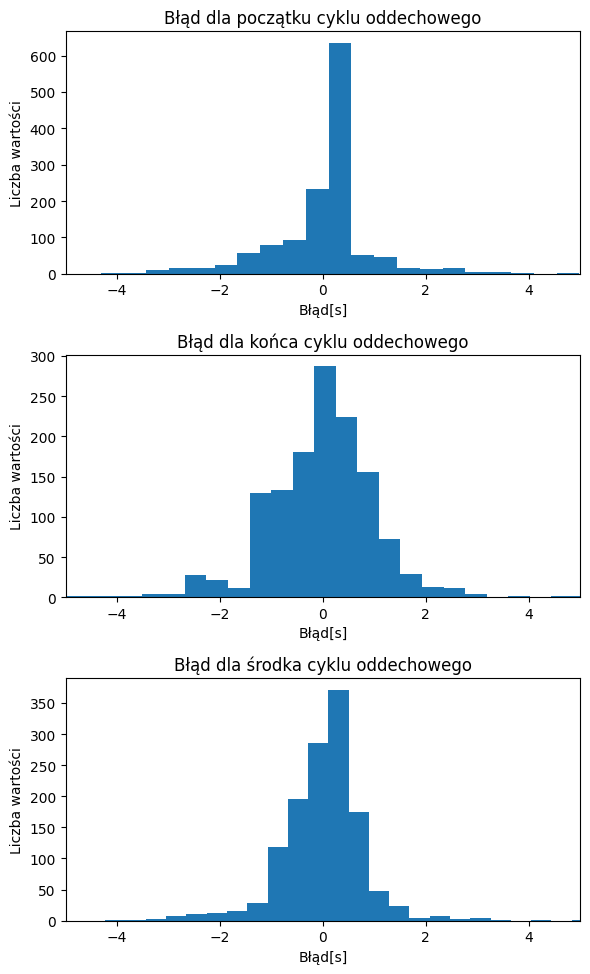

-Mean Errors-
Left Boundary:0.033855056928034144
Right Boundary:0.009605832438238477
Centre:0.021730444683136393


In [53]:
boundaryDiffOptimal = calculateBoundaryError(testFileNames, testPeakData, optimalPadding)
plotBoundaryErrorSummary("", *boundaryDiffOptimal)

# Validation of the offset values

The Left/Right boundary errors are still mainly centred around 0s, with the mean errors also being fairly small (on the order of $10^{-4}$ seconds), indicating that fitting a simple constant to the training set yields results that generalize well.

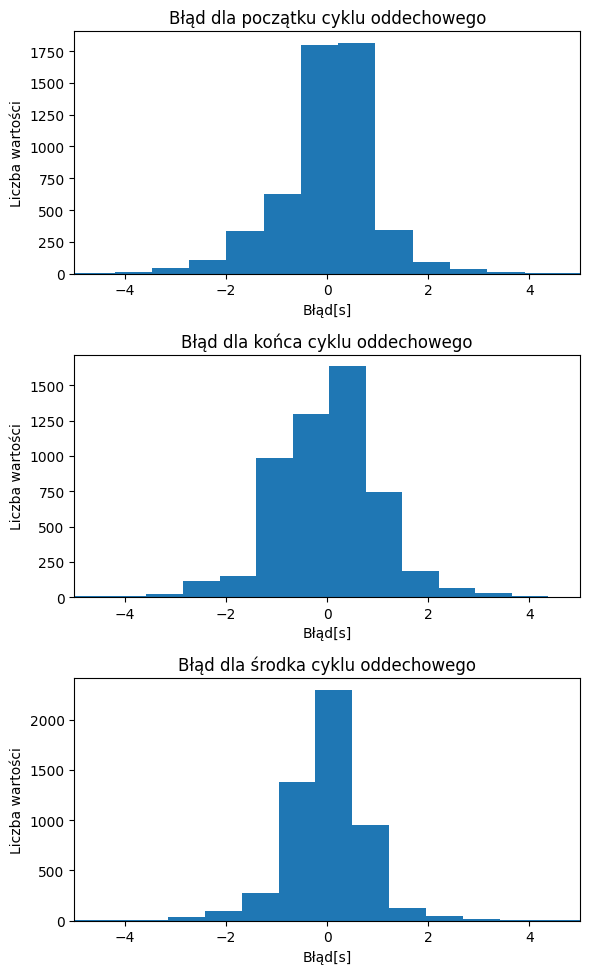

-Mean Errors-
Left Boundary:-0.01060985513536996
Right Boundary:-0.019732244587922557
Centre:-0.015171049861646252


In [55]:
boundaryDiffOptimalValidation = calculateBoundaryError(trainFileNames, trainPeakData, optimalPadding)
plotBoundaryErrorSummary("", *boundaryDiffOptimalValidation)

In [19]:
#Comparison between distribution of detected cycle times.
handAnnotatedWidths = []
for _, cycleInfoList in fileInfoDict.items():
    for cycleInfo in cycleInfoList:
        handAnnotatedWidths.append(cycleInfo[1] - cycleInfo[0])

peakDetectionWidths = []
for peaks in peakData:
    paddingOffset = sum(optimalPadding) #The times are before the left/right pads are added to the sample, re-add pad to get actual extracted length
    for leftRightBoundary in peaks[2]:
        peakDetectionWidths.append(leftRightBoundary[1] - leftRightBoundary[0] + paddingOffset)
        
print("No. of cycles from Hand Annotation:{0}".format(len(handAnnotatedWidths)))
print("No. of cycles from Peak Detection:{0}".format(len(peakDetectionWidths)))
print("95th Percentile of Peak Detection Cycle Lengths:{:.2f}s".format(np.percentile(peakDetectionWidths, 95)))

# nBins = 50
# plt.figure(figsize=(16,5))
# plt.hist(handAnnotatedWidths, nBins, alpha=0.5, label='Hand Annotated')
# plt.hist(peakDetectionWidths, nBins, alpha=0.5, label='Peak Detection Method (Inclusive of padding)')
# plt.title("Cycle Widths(s) from Manual Annotation v.s. Peak Detection")
# plt.ylabel("No. of cycles")
# plt.xlabel("Cycle Length(s)")
# plt.legend(loc='upper right')
# plt.show()

No. of cycles from Hand Annotation:6898
No. of cycles from Peak Detection:10089
95th Percentile of Peak Detection Cycle Lengths:3.84s


In [49]:
deases_dict = {}
for index, x in enumerate(fileInfoDict):
    deases_dict[x] = {
            "crackles": False, 
            "wheezes": False, 
            "hand_cycles_no": len(fileInfoDict[x]),
            "annotated_cycles_no": len(peakData[index][1]),
            "audio_length": librosa.get_duration(path="C:/Users/u144572/self_development/mgr/Respiratory_Sound_Database/audio_and_txt_files/" + x + ".wav"),
            "rr": round(len(fileInfoDict[x])/(librosa.get_duration(path="C:/Users/u144572/self_development/mgr/Respiratory_Sound_Database/audio_and_txt_files/" + x + ".wav")/60),2)
    }
    for y in fileInfoDict[x]:
            if y[2] == True:
                deases_dict[x]["crackles"] = True
            if y[3] == True:
                deases_dict[x]["wheezes"] = True

healthy_cycles_no = 0
healthy_length = 0

crackles_cycles_no = 0
crackles_length = 0

wheezes_cycles_no = 0
wheezes_length = 0

both_cycles_no = 0
both_length = 0

for type in ["hand_cycles_no", "annotated_cycles_no"]:
    healthy_cycles_no = 0
    healthy_length = 0

    crackles_cycles_no = 0
    crackles_length = 0

    wheezes_cycles_no = 0
    wheezes_length = 0

    both_cycles_no = 0
    both_length = 0
    for x in deases_dict:
        if deases_dict[x]["crackles"] == True and deases_dict[x]["wheezes"] == True:
            both_cycles_no += deases_dict[x][type]
            both_length += deases_dict[x]["audio_length"]
        if deases_dict[x]["crackles"] == False and deases_dict[x]["wheezes"] == True:
            wheezes_cycles_no += deases_dict[x][type]
            wheezes_length += deases_dict[x]["audio_length"]
        if deases_dict[x]["crackles"] == True and deases_dict[x]["wheezes"] == False:
            crackles_cycles_no += deases_dict[x][type]
            crackles_length += deases_dict[x]["audio_length"]
        else:
            healthy_cycles_no += deases_dict[x][type]
            healthy_length += deases_dict[x]["audio_length"]

    healthy_rr = healthy_cycles_no/(healthy_length/60)
    crackles_rr = crackles_cycles_no/(crackles_length/60)
    wheezes_rr = wheezes_cycles_no/(wheezes_length/60)
    both_rr = both_cycles_no/(both_length/60)
    # print(healthy_rr, crackles_rr, wheezes_rr, both_rr)

for type in ["hand_cycles_no", "annotated_cycles_no"]:
    healthy_cycles_no = 0
    healthy_length = 0

    crackles_cycles_no = 0
    crackles_length = 0

    wheezes_cycles_no = 0
    wheezes_length = 0

    both_cycles_no = 0
    both_length = 0

    total_cycles_no = 0
    total_length = 0
    count = 0
    for x in deases_dict:
        if "Meditron" in x:
            total_cycles_no += deases_dict[x][type]
            total_length += deases_dict[x]["audio_length"]
            if deases_dict[x]["crackles"] == True and deases_dict[x]["wheezes"] == True:
                both_cycles_no += deases_dict[x][type]
                both_length += deases_dict[x]["audio_length"]
            if deases_dict[x]["crackles"] == False and deases_dict[x]["wheezes"] == True:       
                wheezes_cycles_no += deases_dict[x][type]
                wheezes_length += deases_dict[x]["audio_length"]
            if deases_dict[x]["crackles"] == True and deases_dict[x]["wheezes"] == False: 
                count += deases_dict[x][type]
                crackles_cycles_no += deases_dict[x][type]
                crackles_length += deases_dict[x]["audio_length"]
            else:
                healthy_cycles_no += deases_dict[x][type]
                healthy_length += deases_dict[x]["audio_length"]

    healthy_rr = healthy_cycles_no/(healthy_length/60)
    crackles_rr = crackles_cycles_no/(crackles_length/60)
    wheezes_rr = wheezes_cycles_no/(wheezes_length/60)
    both_rr = both_cycles_no/(both_length/60)
    total_rr = total_cycles_no/(total_length/60)
    print(
        round(total_rr, 2), 
        round(healthy_rr, 2), 
        round(crackles_rr, 2), 
        round(wheezes_rr, 2), 
        round(both_rr, 2),
        count)

# X = ['średnia','zdrowa','świsty','rzężenia', "świsty i rzężenia"] 
# hand = [20.93, 21.17, 20.52, 20.15, 19.42] 
# method = [30.61, 30.48, 31.05, 30.36, 30.81] 
  
# X_axis = np.arange(len(X)) 

# # plt.figure(figsize=(16,5))  
# plt.bar(X_axis - 0.2, hand, 0.4, label = 'Girls') 
# plt.bar(X_axis + 0.2, method, 0.4, label = 'Boys') 
  
# plt.xticks(X_axis, X) 
# plt.xlabel("Groups") 
# plt.ylabel("Number of Students") 
# plt.title("Number of Students in each group") 
# plt.legend() 
# plt.show() 

22.24 23.14 20.15 23.62 20.5 397
27.32 27.27 27.46 26.9 25.58 541


In [21]:
def clamp(val, lowerInclusive, upperInclusive):
    if val > upperInclusive:
        return upperInclusive
    elif val < lowerInclusive:
        return lowerInclusive
    else:
        return val
    
#(timeSegments:(left_seconds:float, right_seconds:float), audioSamples:float[], sampleRate:int) => float[][]
def sliceAudio(timeSegments, audioSamples, sampleRate):
    maxSampleIdx = len(audioSamples) - 1
    segments = []
    for boundaries in timeSegments:
        left = clamp(int(boundaries[0] * sampleRate), 0, maxSampleIdx)
        right = clamp(int(boundaries[1] * sampleRate), 0, maxSampleIdx)
        segments.append(audioSamples[left:right])
    return segments

#(rawAudio:float[], 
# peakInfo:(smoothedSignal:float[], peakTiming:seconds[], peakLeftRightBoundaries:(left:float,right:float)[]), 
# padding:(left:float, right:float), 
# sampleRate:int)
#   => (audioClips:float[][], peakTimes:float[], leftRightBoundaries:(float,float)[])
def extractAudioWithPeakInfo(rawSignal, peakInfo, padding, sampleRate):
    maxSampleIdx = len(rawSignal) - 1
    maxTime = maxSampleIdx * sampleRate
    leftPadding, rightPadding = padding
    leftRightBoundaries = [(clamp(left - leftPadding, 0, maxTime), clamp(right + rightPadding, 0, maxTime)) for left, right in peakInfo[2]]
    audioSegments = sliceAudio(leftRightBoundaries, rawSignal, sampleRate)
    return (audioSegments, peakInfo[1], leftRightBoundaries)

#Get sample slices
#(audioClips:float[][], peakTimes:float[], leftRightBoundaries:(float,float)[])[]
extractedAudioClips = [extractAudioWithPeakInfo(signal, peakInfo, optimalPadding,gSampleRate) for signal, peakInfo in zip(noiseRemoved, peakData)]

# Results
Have a listen to some of the automatically extracted clips. This method works reasonably well when the audio source isn't flooded with noise, but tends to generate overlapping clips for noiser sources.

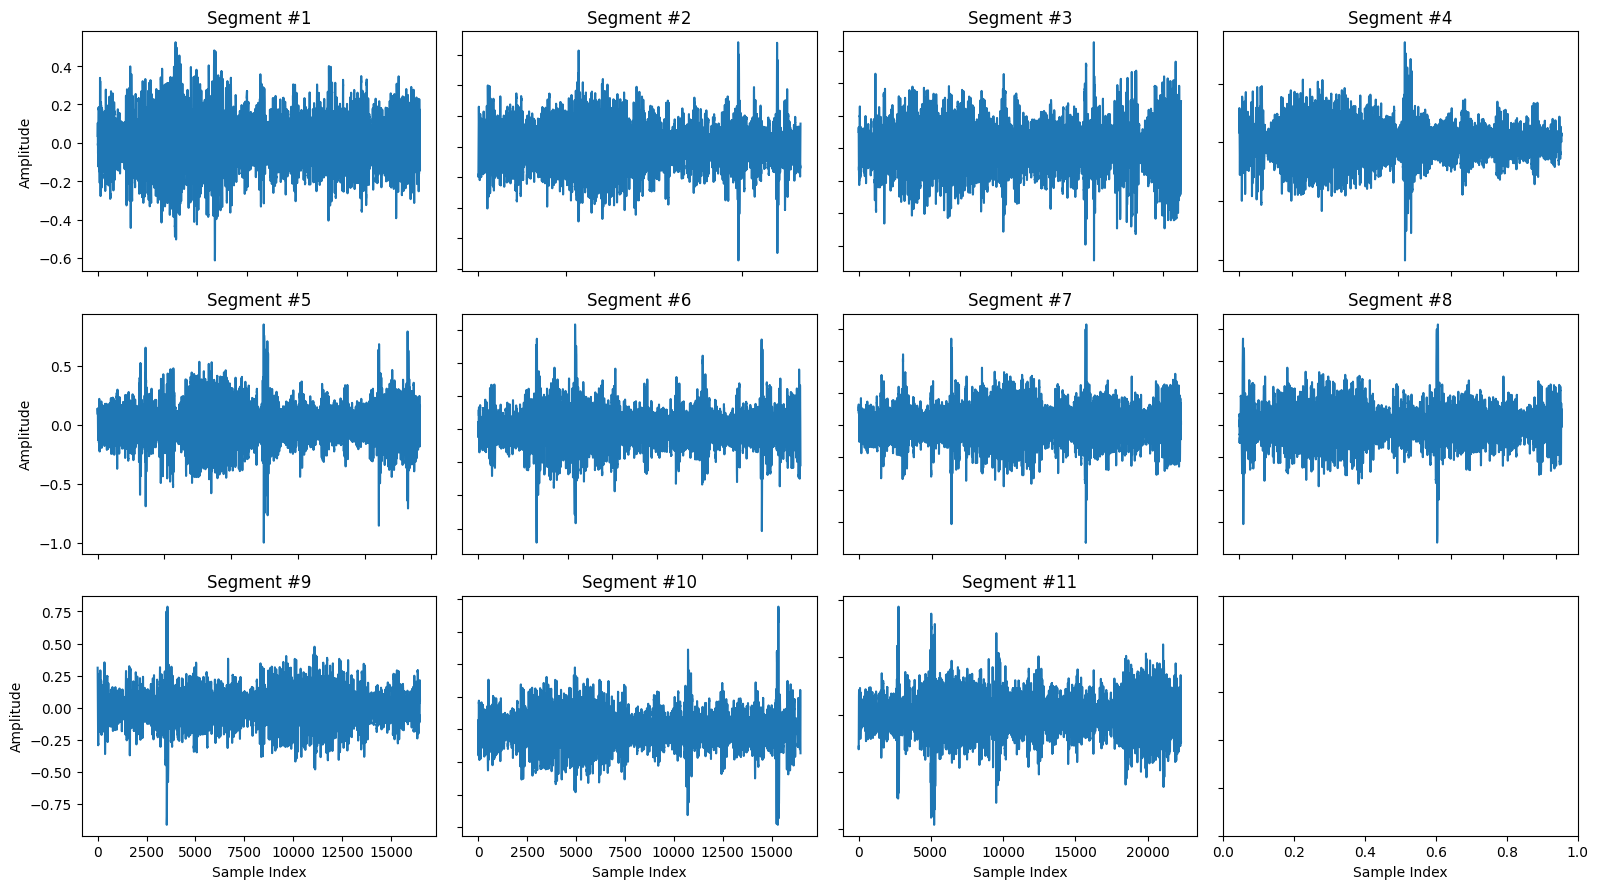

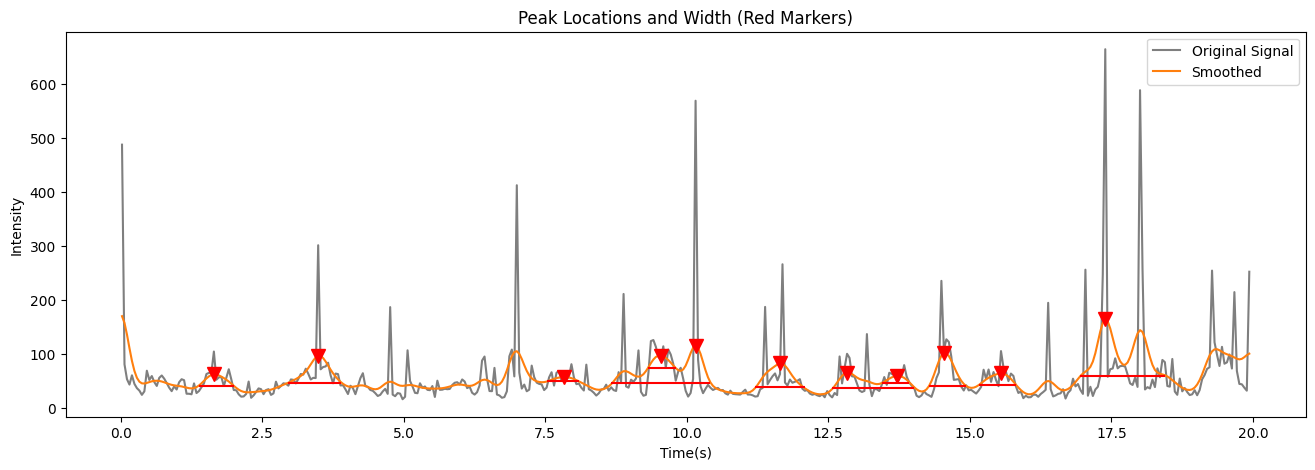

Original


Segment #1


Segment #2


Segment #3


Segment #4


Segment #5


Segment #6


Segment #7


Segment #8


Segment #9


Segment #10


Segment #11


In [22]:
def plotAllSamples(audioSegments):
    nPlots = len(audioSegments)
    cols = int(math.ceil(math.sqrt(nPlots)))
    rows = math.ceil(nPlots / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(16,9))
    for idx, sample in enumerate(audioSegments):
        row = idx // cols
        col = idx % cols
        ax = axs[row, col]
        ax.plot(sample)
        ax.set_title("Segment #{0}".format(idx + 1))
        
    for ax in axs.flat:
        ax.set(xlabel='Sample Index', ylabel='Amplitude')

    for ax in axs.flat:
        ax.label_outer()
        
    plt.tight_layout()   
    plt.show()
    
#plotAllSamples(onlyPeaks)
idx = 1
selectedClip = extractedAudioClips[idx][0]
plotAllSamples(selectedClip)
time, amp = getPowerEnvelop(spectrograms[idx], upperCutoffFreq, False)
_  = findPeaksAndWidthsFromSmoothedCurve(amp, time, windowSizeSeconds, plot=True)
print("Original")
ipd.display(ipd.Audio(audioBuffers[idx], rate=gSampleRate))
for i in range(len(selectedClip)):
    print("Segment #{0}".format(i + 1))
    ipd.display(ipd.Audio(selectedClip[i], rate=gSampleRate))

# Transfer of labels

Dataset labels for the presence of crackles/wheezes can be transferred using an intersection over union approach(IoU).

If the extracted sample entirely covers a hand-annotated label with a positive crackle/wheeze label, it will assume the label of the hand-annotated cycle. Otherwise, positive labels will only be copied if the IoU between the estimated cycle and hand annotated label is greater than 50%.

In [31]:
#(containingRegion:(left:float,right:float), targetRegion:(left:float,right:float)) => overlapFrac(0-1):float
def getOverlapFrac(containingRegion, targetRegion):
    overlap = max(0, min(containingRegion[1], targetRegion[1]) - max(containingRegion[0], targetRegion[0]))
    overlapFrac = overlap / (targetRegion[1] - targetRegion[0])
    return overlapFrac

def fracOfSampleCovered(groundTruth, autoDetectedWindow):
    overlap = max(0, min(groundTruth[1], autoDetectedWindow[1]) - max(groundTruth[0], autoDetectedWindow[0]))
    fracOfSampleCovered = overlap / (groundTruth[1] - groundTruth[0])
    return fracOfSampleCovered

#Applying labels to auto-extracted data
#(hand-annotated-labels:(start, end, hasCrackles, hasWheezes)[], auto-extracted-segments:(left,right)[], minOverlapFrac(0-1):float) => 
#transfered-labels:(left,right, hasCrackles, hasWheezes)[]
#Any segment where the overlap ratio with a hand annotated segment is more than <minOverlapFrac> will have the crackles/wheezes label applied
#minOverlapFrac is defined as the intersection between the hand-annotated segment and auto-detected segment, divided by the size of the auto-detected segment
def transferLabelToExtractedSegment(handAnnotation, automaticSegmentTimes, minOverlapFrac):
    transferredLabels = []
    handAnnotatedSegments = [(left, right) for left, right, _ , _ in handAnnotation]
    handAnnotatedLabels = [(hasCrackles, hasWheezes) for _, _, hasCrackles, hasWheezes in handAnnotation]
    for autoSegment in automaticSegmentTimes:
        overlapFractions = [getOverlapFrac(groundTruth, autoSegment) for groundTruth in handAnnotatedSegments]
        fracOfAnnSampleCovered = [fracOfSampleCovered(groundTruth, autoSegment) for groundTruth in handAnnotatedSegments]
        allSelectedLabels = [labels if (oFrac > minOverlapFrac or sFrac > minOverlapFrac) else (False, False) for oFrac, sFrac, labels in zip(overlapFractions,fracOfAnnSampleCovered, handAnnotatedLabels)]
        hasCrackles = any([bCrackles for bCrackles, _ in allSelectedLabels])
        hasWheezes = any([bWheezes for _, bWheezes in allSelectedLabels])
        transferredLabels.append((*autoSegment, hasCrackles, hasWheezes))
    return transferredLabels

#illustrative purposes
testIdx = 0
handAnnotations = fileInfoList[testIdx]
autoExtractedSegments = extractedAudioClips[testIdx][2]
print(handAnnotations)
#print(autoExtractedSegments)
print(transferLabelToExtractedSegment(handAnnotations, autoExtractedSegments, 0.5))

[(0.036, 0.579, False, False), (0.579, 2.45, False, False), (2.45, 3.893, False, False), (3.893, 5.793, False, False), (5.793, 7.521, False, False), (7.521, 9.279, False, False), (9.279, 11.15, False, False), (11.15, 13.036, False, False), (13.036, 14.721, False, False), (14.721, 16.707, False, False), (16.707, 18.507, False, False), (18.507, 19.964, False, False)]
[(0.5094285714285713, 2.9071428571428575, False, False), (1.4304285714285714, 4.3105714285714285, False, False), (2.8777142857142857, 6.152571428571429, False, False), (6.6932857142857145, 9.617285714285714, False, False), (8.623000000000001, 11.196142857142856, False, False), (9.631714285714287, 13.082, False, False), (15.464714285714287, 18.871142857142857, False, False)]


In [ ]:
#Apply annotation transfer to all cycles.

#(handAnnotationList:(start, end, hasCrackles, hasWheezes)[],
# autoSegmentList:(audioClips:float[][], peakTimes:float[], leftRightBoundaries:(float,float)[])[], 
# minOverlapFrac:float) =>
#    autoSegmentWithLabels(audioClips:float[][], peakTimes:float[], cycleInfo:(float,float, hasCrackles, hasWheezes)[])[]
def transferLabels(handAnnotationList, autoSegmentList, minOverlapFrac):
    autoSegmentWithTransferLabels = []
    for handAnn, autoSeg in zip(handAnnotationList,autoSegmentList):
        xferredLabels = transferLabelToExtractedSegment(handAnn, autoSeg[2], minOverlapFrac)
        autoSegmentWithTransferLabels.append((autoSeg[0], autoSeg[1], xferredLabels))
    return autoSegmentWithTransferLabels
                                             
minOverlapFrac = 0.5
transferredLabels = transferLabels(fileInfoList, extractedAudioClips, minOverlapFrac)

# Extra: Training of a CNN using the extracted samples

While not the focus of this notebook, the automatically extracted samples will be used to train a CNN to differentiate between healthy breathing sound clips, and those which contain wheezes and/or crackles (binary classification).

Basic details are as follows:
* Input Features: Mel-Spectograms
    * Classes (2)
       1. Healthy
       2. Wheezes, Crackles or Both
* Data Augmentation
    * Frequency & Time masking
    * Temporal distortion (The spectrogram is stretched/squeezed at 2 different points)
    * Variable spectrogram starting delay (i.e. the entire spectrogram is shifted right by a random amount)

In [ ]:
nAudioClips = len(fileInfoList)
indices = range(0, nAudioClips)

trainIndices, testIndices = train_test_split(indices, test_size=0.2, random_state=0xDEADBEEF)

#Normalizes all spectrograms on a per spectrogram basis
#(segmentsWithLabels:(audioClips:float[][], peakTimes:float[], cycleInfo:(float,float, hasCrackles, hasWheezes)[])[],
# windowSize(seconds):float, sampleRate:int) =>
#    (spectrogram:float[][][], labels(hasCrackles, hasWheezes)[])[]
def getCorrespondingSpectroGrams(segmentsWithLabels, windowSize, sampleRate, fftSampleWindowSize):
    extractedSpectrogramList = []
    maxSamples = int(windowSize * sampleRate)
    for segmentInfo in segmentsWithLabels:
        clipInfo = []
        for idx, cycleInfo in enumerate(segmentInfo[2]):
            sampleBuffer = np.zeros(maxSamples)
            audioClip = segmentInfo[0][idx]
            #If the extracted clip can fit within the window
            #Simply copy it to the front of the buffer
            if len(audioClip) <= maxSamples:
                sampleBuffer[:len(audioClip)] = audioClip
            #Otherwise, fit the centre of the peak into the buffer
            else:
                nClipSamples = len(audioClip)
                peakTiming = segmentInfo[1][idx]
                left, right = cycleInfo[:2]
                peakIdx = int((peakTiming - left) * sampleRate)
                rightIdx = int(min(peakIdx + (maxSamples // 2), nClipSamples))
                leftIdx = int(max(0, rightIdx - maxSamples))
                sampleBuffer[:(rightIdx - leftIdx)] = audioClip[leftIdx: rightIdx]
            labels = cycleInfo[2:]
            
            melSpec = librosa.feature.melspectrogram(sampleBuffer, sr=sampleRate,  n_fft=fftSampleWindowSize)
            melMin = np.min(melSpec)
            melMax = np.max(melSpec)
            melNorm = melSpec / (melMax - melMin)
            clipInfo.append((np.power(melNorm, 0.2), labels))
        extractedSpectrogramList.append(clipInfo)
    return extractedSpectrogramList

modelWindowSize = 4.0 #(seconds) to fit 95th percentile of sample widths
fftWindowSizeSeconds = 0.025
fftWindowSizeSamples = int(fftWindowSizeSeconds * gSampleRate)

trainingSet = multiIndexList(transferredLabels, trainIndices)
testSet = multiIndexList(transferredLabels, testIndices)

trainingLabelledSpectrograms = getCorrespondingSpectroGrams(trainingSet, modelWindowSize, gSampleRate, fftWindowSizeSamples)
testLabelledSpectrograms = getCorrespondingSpectroGrams(testSet, modelWindowSize, gSampleRate, fftWindowSizeSamples)

/opt/conda/lib/python3.7/site-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


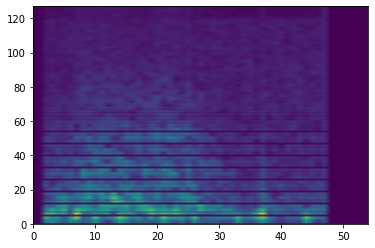

In [ ]:
plt.pcolormesh(trainingLabelledSpectrograms[0][0][0], shading='gouraud')

In [ ]:
#(spectrogram:float[][], labels(hasCrackles, hasWheezes)[])[] -> (flattened_spectrogram[], hasCrackles[], hasWheezes[])
def flattenLabelledData(labelledData):
    flattenedSpectrograms = []
    crackleList = []
    wheezesList = []
    for specLabelPairList in labelledData:
        for idx, specLabelPair in enumerate(specLabelPairList):
            spec, label = specLabelPair
            #flattenedSpectrograms.append(spec.reshape(-1))
            #flattenedSpectrograms.append(spec.flatten('F')) 
            flattenedSpectrograms.append(spec) 
            crackleList.append(label[0])
            wheezesList.append(label[1])
    #return (flattenedSpectrograms, crackleList, wheezesList)
    return (flattenedSpectrograms, crackleList, wheezesList)

trainSpec1D, trainCrackleLabels, trainWheezeLabels = flattenLabelledData(trainingLabelledSpectrograms)
testSpec1D, testCrackleLabels, testWheezeLabels = flattenLabelledData(testLabelledSpectrograms)

In [ ]:
inputRows, inputCols = trainSpec1D[0].shape

def getLabels(crackleList, wheezeList):
    oneHotLabels = {
        (False, False): [1,0],
        (True, False): [0,1],
        (False, True): [0,1],
        (True, True): [0,1]
    }
    oneHot = []
    for crackleWheezePair in zip(crackleList, wheezeList):
        oneHot.append(oneHotLabels[crackleWheezePair])
    return np.array(oneHot)

trainLabels = getLabels(trainCrackleLabels, trainWheezeLabels)
trainingDataNp = np.reshape(np.array(trainSpec1D), (-1,inputRows, inputCols,1))

testLabels = getLabels(testCrackleLabels, testWheezeLabels)
testDataNp = np.reshape(np.array(testSpec1D), (-1,inputRows, inputCols,1))

In [ ]:
trainTotalPerClass = np.sum(trainLabels, axis=0)
trainClassWeights = np.sum(trainTotalPerClass) / trainTotalPerClass
trainClassWeightsDict = dict(enumerate(trainClassWeights))
print(trainTotalPerClass)
print(trainClassWeightsDict)

[4160 3833]
{0: 1.9213942307692307, 1: 2.0853117662405425}


In [ ]:
import random 

def spectorgramTemporalDistortion(spectrogram, col1, col2, offset1, offset2):
    nRows, nCols = spectrogram.shape
    colIndices = np.arange(nCols)
    remappedCols = np.array([0, col1 + offset1, col2 + offset2, nCols - 1])
    originalCols = np.array([0, col1, col2, nCols - 1]) 
    remappedIndices = np.interp(colIndices, originalCols, remappedCols)
    
    distorted = np.zeros((nRows, nCols))
    for row in range(nRows):
        distorted[row,:] = np.interp(remappedIndices, colIndices, spectrogram[row,:])
    return distorted

def blotOutRow(spectrogram, row, width):
    nRows, _ = spectrogram.shape
    rowIndices = np.arange(nRows)
    dipBegin = clamp(row - width /2 , 0, nRows - 1)
    dipEnd = clamp(row + width /2, 0, nRows - 1)
    amp = np.array([1,1,0,1,1])
    indices = np.array([0, dipBegin, row, dipEnd, nRows - 1])
    scalingFactor = np.interp(rowIndices, indices, amp)
    blotted = scalingFactor[:,None] * spectrogram
    return blotted
    
def blotOutCol(spectrogram, col, width):
    _ , nCols = spectrogram.shape
    colIndices = np.arange(nCols)
    dipBegin = clamp(col - width /2 , 0, nCols - 1)
    dipEnd = clamp(col + width /2, 0, nCols - 1)
    amp = np.array([1,1,0,1,1])
    indices = np.array([0, dipBegin, col, dipEnd, nCols - 1])
    scalingFactor = np.interp(colIndices, indices, amp)
    blotted = scalingFactor[None,:] * spectrogram
    return blotted

def offsetSpectrogram(spectrogram, xOffset):
    nRows, nCols = spectrogram.shape
    offsetCopy = np.zeros((nRows, nCols))
    nColsToTake = nCols - xOffset
    offsetCopy[:,xOffset:] = spectrogram[:,:nColsToTake]
    return offsetCopy

def randomlyApplyDistortions(spectrogram, temporalProb, rowBlotProb, colBlotProb, offsetProb):
    acc = spectrogram
    nRows , nCols = spectrogram.shape
    
    if random.random() < offsetProb:
        offset = int(random.uniform(0, nCols * 0.3))
        acc = offsetSpectrogram(acc, offset)
        
    if random.random() < temporalProb:
        col1Centre = nCols * 0.25
        col2Centre = nCols * 0.7
        col1 = col1Centre + random.uniform(-nCols * 0.1, nCols * 0.1)
        col2 = col2Centre + random.uniform(-nCols * 0.1, nCols * 0.1)
        offset1 = random.uniform(-nCols * 0.075, nCols * 0.075)
        offset2 = random.uniform(-nCols * 0.075, nCols * 0.075)
        acc = spectorgramTemporalDistortion(acc, col1, col2, offset1, offset2)
        
    if random.random() < rowBlotProb:
        row = random.uniform(0, nRows - 1)
        width = random.uniform(1, nRows * 0.1)
        acc = blotOutRow(acc, row, width)
    
    if random.random() < colBlotProb:
        col = random.uniform(0, nCols - 1)
        width = random.uniform(1, nCols * 0.1)
        acc = blotOutCol(acc, col, width)

    return acc

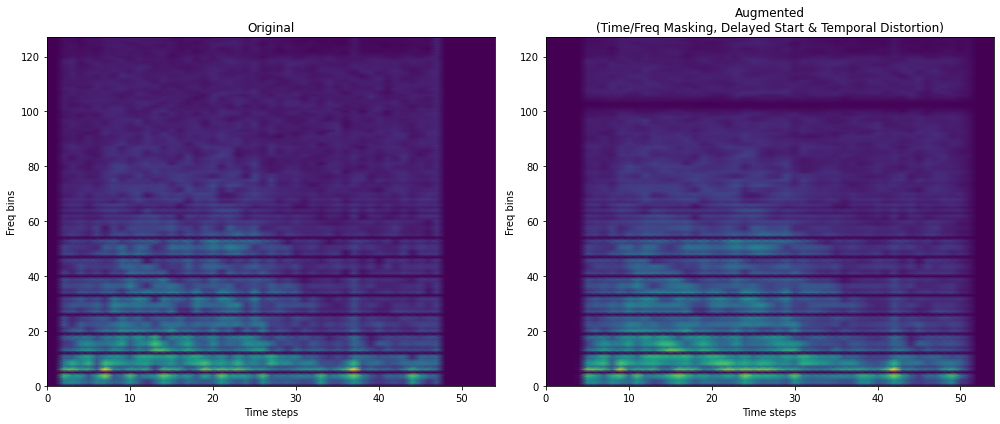

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(14,6))

axs[0].set_title("Original")
axs[0].pcolormesh(trainingLabelledSpectrograms[0][0][0], shading='gouraud')

augmented = randomlyApplyDistortions(trainingLabelledSpectrograms[0][0][0], 1, 1, 1, 1)
axs[1].set_title("Augmented\n(Time/Freq Masking, Delayed Start & Temporal Distortion)")
axs[1].pcolormesh(augmented, shading='gouraud')
 
for ax in axs.flat:
    ax.set(xlabel='Time steps', ylabel='Freq bins')    
        
plt.tight_layout() 
plt.show()

In [ ]:
from tensorflow.keras.utils import Sequence

class SpectrogramSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffleIndices()
    
    def shuffleIndices(self):
        nSamples = len(self.x)
        indices = np.arange(nSamples)
        np.random.shuffle(indices)
        self.indices = indices
    
    def on_epoch_end(self):
        self.shuffleIndices()
        
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        startingIdx = idx * self.batch_size
        endingIdx = (idx + 1) * self.batch_size
        selecedIndices = self.indices[startingIdx:endingIdx]
        
        rawSpectrogramBatch = np.reshape(self.x[selecedIndices], (-1,inputRows, inputCols))
        augmentedSpectrograms = np.array([randomlyApplyDistortions(spectrogram, 0.5, 0.25, 0.25, 0.75) for spectrogram in rawSpectrogramBatch])
        
        batch_x = np.reshape(augmentedSpectrograms, (-1,inputRows, inputCols, 1))
        batch_y = self.y[selecedIndices]

        return (batch_x, batch_y)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

keras.backend.clear_session()

model = keras.Sequential(
    [
        layers.InputLayer(input_shape=(inputRows, inputCols, 1)),
        
        layers.Conv2D(96, 7),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2),
        
        layers.Conv2D(128, 5),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2),
        
        layers.Conv2D(128, 3),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2),
        layers.SpatialDropout2D(0.1),
        
        layers.Conv2D(256, 3),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(2),
        layers.SpatialDropout2D(0.1),
        
        layers.Flatten(),
        
        layers.Dense(4096),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.5),
        
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.1),
        
        layers.Dense(2, activation='Softmax')
    ]
)

opt = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

2021-12-16 15:36:53.639138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 15:36:53.755135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 15:36:53.756255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 122, 49, 96)       4800      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 122, 49, 96)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 24, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 20, 128)       307328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 57, 20, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 10, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 8, 128)        1

2021-12-16 15:36:53.758886: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-16 15:36:53.760037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 15:36:53.761036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 15:36:53.762107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [ ]:
batch_size=128
generator = SpectrogramSequence(trainingDataNp, trainLabels, batch_size)
history = model.fit(
    x=generator,
    epochs=100, #class_weight=trainClassWeightsDict,
    validation_data=(testDataNp, testLabels))

2021-12-16 15:36:56.438866: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-12-16 15:36:57.948927: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


63/63 [==============================] - 13s 89ms/step - loss: 0.6907 - acc: 0.5227 - val_loss: 0.6955 - val_acc: 0.4561
Epoch 2/100
63/63 [==============================] - 5s 77ms/step - loss: 0.6854 - acc: 0.5331 - val_loss: 0.6896 - val_acc: 0.5258
Epoch 3/100
63/63 [==============================] - 5s 81ms/step - loss: 0.6799 - acc: 0.5581 - val_loss: 0.6816 - val_acc: 0.5711
Epoch 4/100
63/63 [==============================] - 5s 77ms/step - loss: 0.6748 - acc: 0.5676 - val_loss: 0.6933 - val_acc: 0.5363
Epoch 5/100
63/63 [==============================] - 5s 82ms/step - loss: 0.6726 - acc: 0.5687 - val_loss: 0.6904 - val_acc: 0.5615
Epoch 6/100
63/63 [==============================] - 5s 76ms/step - loss: 0.6717 - acc: 0.5754 - val_loss: 0.6672 - val_acc: 0.5840
Epoch 7/100
63/63 [==============================] - 6s 88ms/step - loss: 0.6693 - acc: 0.5883 - val_loss: 0.6824 - val_acc: 0.5725
Epoch 8/100
63/63 [==============================] - 5s 77ms/step - loss: 0.6719 - acc:

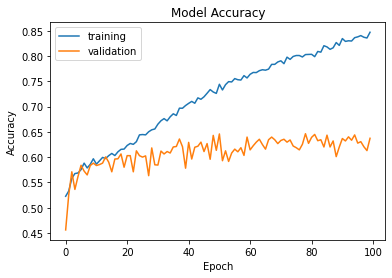

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'])
plt.show()

In [ ]:
predictions = model.predict(testDataNp)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

groundTruthClasses = np.argmax(testLabels, axis = 1)
predictedClasses = np.argmax(predictions, axis = 1)

print(classification_report(groundTruthClasses, 
                            predictedClasses, 
                            target_names = ['none','crackles, wheezes or both']))
print(confusion_matrix(groundTruthClasses, predictedClasses))
print("Overall Accuracy: {0}".format(accuracy_score(groundTruthClasses, predictedClasses)))

                           precision    recall  f1-score   support

                     none       0.59      0.65      0.62       956
crackles, wheezes or both       0.68      0.62      0.65      1140

                 accuracy                           0.64      2096
                macro avg       0.64      0.64      0.64      2096
             weighted avg       0.64      0.64      0.64      2096

[[625 331]
 [429 711]]
Overall Accuracy: 0.6374045801526718
